In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import math

import pickle
import os

In [2]:
np.random.seed(10)

# #network configuraiton
# v_size = 21
# h_size = 50

In [3]:
import mnist_utils as mu
train_x, train_y = mu.get_train_data()
train_x /=255.
v_size = 794
h_size = 500

In [4]:
#weights initialization
w_bound = 0.5 #0.3
w_init = 0.1 #0.1
# w = np.random.uniform(-w_init, w_init, (v_size, h_size)) 
w_offset = 0.05
w = np.random.normal(w_offset, w_init, (v_size, h_size)) 

#LIF neuron parameters
v_thresh = 1.   # membrane potential threshold
v_rest = 0.     # resting potential
tau_m = 20.     # membrane constant
delay = 5       # synaptic delay

#STDP config
tau_stdp = 20   # STDP window length
eta = 0.001  # learning rate
delta_w = eta*np.logspace(0,1,tau_stdp)  #expenential decaying STDP curve



run_len = 50      # Length of each trial
teach_delay = 10  # Delay length of the teaching signal
K = 30.
record_flag = True #False

In [5]:
# # Setting up the patterns to learn
# patterns = list()
# # # patterns.append([3,3,3,3,5,5,5,5,8,8,3,3,3,3,5,5,5,5,8,8])
# # # patterns.append([2,2,2,2,2,8,8,8,8,8,2,2,2,2,2,8,8,8,8,8])
# patterns.append([2,2,2,2,2,2,2,2,2,2,2,2,2,2,16,16,16,16,16,16,16]) #1,1,0 #16,16,16,16,16,16,16   #8,8,8,8,8,8,8
# patterns.append([2,2,2,2,2,2,2,16,16,16,16,16,16,16,2,2,2,2,2,2,2]) #1,0,1
# patterns.append([16,16,16,16,16,16,16,2,2,2,2,2,2,2,2,2,2,2,2,2,2]) #0,1,1

# patterns = np.array(patterns)
# print patterns.shape

In [6]:
num_test = 10
patterns = np.int16(np.floor((1.-train_x[:num_test])*K ))
patterns_y = np.zeros((num_test, 10))
patterns_y[range(num_test), np.int16(train_y[:num_test])] = 1.
patterns_y = np.int16(np.floor((1.-patterns_y[:num_test])*K ))
patterns = np.append(patterns,patterns_y, axis=1)


In [7]:
epoch = 5 # training epochs

# Recording of the neural status
if record_flag:
#     h_mem_list = []     # membrane potential of hiden units 
#     h_spike_list = []   # spikes of hiden units 
#     o_mem_list = []     # membrane potential of output units 
#     o_spike_list = []   # spikes of output units 
    w_list = []         # weights
    loss_list = []
    predict_list = []

# Initialise neural status
h_spike = np.zeros((h_size, run_len))   # no output spikes from hiden units 
o_spike = np.zeros((v_size, run_len))   # no output spikes from ouput units 
h_mem = np.zeros((h_size, 1))           # membrane potential=0 mV for hiden units 
o_mem = np.zeros((v_size, 1))           # membrane potential=0 mV for output units 

for iteration in range(epoch):
    print 'epoch:%d'%iteration
    for p_id in range(patterns.shape[0]):
        # reset the neural status
        h_mem[:] = v_rest
        o_mem[:] = v_rest
        h_spike[:,:] = v_rest
        o_spike[:,:] = v_rest
        
        # the input spikes and the teaching signal
        v_spike = np.zeros((v_size, run_len))
        v_teach = np.zeros((v_size, run_len))
        
        v_pattern = np.copy(patterns[p_id,:])
        
        # add noise to the input signal
#         v_pattern += np.random.normal(0, 0.1, v_pattern.shape)
#         v_pattern[v_pattern<0] = 0
        
        v_spike[(range(v_size), v_pattern)]=1.
        v_spike[:, K]=0.
        v_teach[(range(v_size), np.array(v_pattern)+teach_delay)] = 1.
        
        # in the period of delay, nothing changed
#         if record_flag:
#             for t in range(delay):
#                 h_mem_list.append(h_mem.copy())
#                 h_spike_list.append(h_spike[:, t].copy())
#                 o_mem_list.append(o_mem.copy())
#                 o_spike_list.append(o_spike[:, t].copy())
#                 w_list.append(w.flatten())
            
        # Main part for neural status updating
        for t in range(delay,run_len):
            # hid units
            h_mem *= np.exp(-1/tau_m)   #decay
            h_mem += np.reshape(np.dot(v_spike[:,t-delay],w),(h_mem.shape))  # add up spiking input
            h_spike[(h_mem>v_thresh)[:,0], t] = 1.  #generate spikes
            h_mem[(h_mem>v_thresh)] = v_rest        #reset membrane potential
            #h_mem[(h_mem<v_rest)] = v_rest

            
            # output units
            o_mem *= np.exp(-1/tau_m)
            o_mem += np.reshape(np.dot(h_spike[:,t-delay],np.transpose(w)),(o_mem.shape))
            o_spike[(o_mem>v_thresh)[:,0], t] = 1.
            o_mem[(o_mem>v_thresh)] = v_rest
            #o_mem[(o_mem<v_rest)] = v_rest


            # t indicates the importance
            impt = np.float(run_len-t+delay)/np.float(run_len)
            
            # weight updates
            left_bound = max(t-tau_stdp+1-delay, 0)
            if (o_spike[:, t]>0).any() or (v_teach[:, t]>0).any():
                
                # Look the spikes of hiden units for a time period of STDP window
                temp_deltaw = np.einsum('jk,k->jk', h_spike[:, left_bound:t-delay+1], delta_w[left_bound-t+delay-1:])

            # W-
                w -= np.sum(np.einsum('i,jk->ijk', o_spike[:, t], temp_deltaw), axis=2)*impt #STDP
                w[o_spike[:, t]>0, :] -= (eta*impt*0.1) # weights decrease even without STDP
            # W+
                w += np.sum(np.einsum('i,jk->ijk', v_teach[:, t], temp_deltaw), axis=2)*impt #STDP
                w[v_teach[:, t]>0, :] += (eta*impt*0.1) # weights increase even without STDP

                w[w>w_bound] = w_bound
                w[w<-w_bound] = -w_bound
            
#             if record_flag:
#                 h_mem_list.append(h_mem.copy())
#                 h_spike_list.append(h_spike[:, t].copy())
#                 o_mem_list.append(o_mem.copy())
#                 o_spike_list.append(o_spike[:, t].copy())
#                 w_list.append(w.flatten())
        if np.mod(p_id,1)==0: #p_id == patterns.shape[0]-1:# and  np.mod(iteration,10) == 9: 
#             print iteration
#             neuron_id, time_stamp = np.where(o_spike==1)
#             plt.plot(time_stamp, neuron_id, '.')
#             plt.xlim((0,run_len))
#             plt.show()
            
            recon = (o_spike.argmax(axis=1)-teach_delay)*1.
            
            recon[recon>=0] = (K-recon[recon>=0])/K
            recon[recon<0] = 0
            
            loss =  ((((K-patterns)/K)[p_id]-recon.flatten()) ** 2).mean()
#             print 'Loss:', ((((K-patterns)/K)[p_id]-recon.flatten()) ** 2).mean()
            
            predict = np.argmax(recon[-10:]) 

#             print 'Predict: ', np.argmax(predict) 
#             print predict
#             recon_img = np.reshape(recon[:-10], (28,28))
#             plt.imshow(recon_img, cmap=cm.gray_r, clim=(0,1))
#             plt.show()
            if record_flag:
                loss_list.append(loss)
#                 predict_list.append(predict)
#                 w_list.append(w.flatten())
                w_list.append(w[-10:,:].flatten())
                print p_id, '%0.3f'%loss, np.int16(train_y[p_id]), predict, '%.2f'%recon[-10+predict]
    if np.mod(iteration,10) == 9:
        delta_w *= 0.8

epoch:0
0 0.839 5 0 1.00
1 0.586 0 0 1.00
2 0.205 4 7 0.93
3 0.195 1 1 0.97
4 0.297 9 3 1.00
5 0.324 2 2 1.00
6 0.125 1 1 1.00
7 0.323 3 3 1.00
8 0.050 1 0 0.00
9 0.179 4 7 1.00
epoch:1
0 0.207 5 5 1.00
1 0.155 0 0 1.00
2 0.069 4 1 0.67
3 0.096 1 1 0.93
4 0.108 9 3 1.00
5 0.159 2 2 1.00
6 0.046 1 1 1.00
7 0.118 3 3 1.00
8 0.034 1 0 0.00
9 0.142 4 7 1.00
epoch:2
0 0.117 5 5 1.00
1 0.094 0 0 1.00
2 0.069 4 4 0.47
3 0.074 1 1 0.93
4 0.081 9 9 0.93
5 0.146 2 2 1.00
6 0.021 1 1 1.00
7 0.105 3 3 1.00
8 0.032 1 1 0.70
9 0.138 4 4 0.93
epoch:3
0 0.090 5 5 1.00
1 0.116 0 0 1.00
2 0.070 4 0 0.00
3 0.057 1 1 1.00
4 0.067 9 9 1.00
5 0.109 2 2 1.00
6 0.041 1 1 1.00
7 0.086 3 3 1.00
8 0.029 1 0 0.00
9 0.120 4 7 1.00
epoch:4
0 0.067 5 5 1.00
1 0.110 0 0 1.00
2 0.073 4 4 0.97
3 0.065 1 1 1.00
4 0.056 9 9 1.00
5 0.136 2 2 1.00
6 0.031 1 1 1.00
7 0.088 3 3 1.00
8 0.026 1 0 0.00
9 0.085 4 4 0.97


-c:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


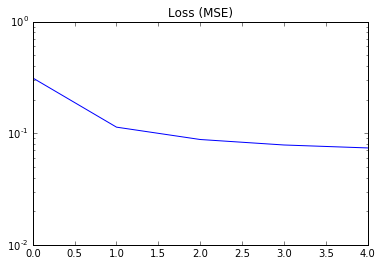

In [8]:
# plt.plot(loss_list)
avg_num = 10
img_num = len(loss_list)
loss_plot = np.reshape(np.array(loss_list), (img_num/avg_num, avg_num))
plt.semilogy(np.average(loss_plot,axis=1))
plt.title('Loss (MSE)')


(50, 5000)


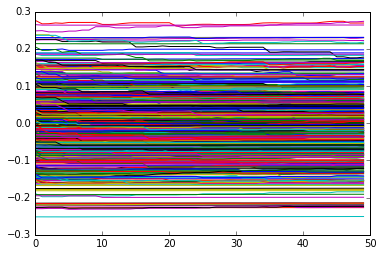

In [9]:
w_list = np.array(w_list)
plt.plot(w_list[:,::10])
print w_list.shape